In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from scipy.interpolate import spline



/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
data_dir = '/Users/gbromley/dropbox/CRUTS4.01/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'cru_ts4.01.1901.2016.pre.dat.nc'
nc_temp = xr.open_dataset(data_dir+temp_file)

ngp_mask = xr.open_dataset('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/ngp_mask.nc')

In [6]:
tmp = nc_temp['pre']

In [3]:
ngp_mask = ngp_mask.rename({'__xarray_dataarray_variable__':'ngp'})

In [4]:
t_season='annual'
t_months=[1,2,3,4,5,6,7,8,9,10,11,12]
start_year = '1970-01-01'
end_year = '2016-01-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38

In [7]:
#extract the time period we are interested in
temp_subset=tmp.sel(time=slice(start_year,end_year))
#grab the months interested in
temp_months = temp_subset.sel(time=extract_months(temp_subset['time.month'],t_months[0],t_months[-1]))
#create month averages
temp_months_avg = temp_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
temp_30= tmp.sel(time=slice('1980-01-01','2011-01-01'))
#grab the months
temp_30_months = temp_30.sel(time=extract_months(temp_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
temp_30_climatology = temp_30_months.mean(dim='time')

In [8]:
#create 2d structure to hold slope
spatial_trend = tmp.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

In [9]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
corr_vals = np.arange(0,len(temp_months_avg))
corr_vals_2 = sm.add_constant(corr_vals)
for i in np.arange(0,len(tmp['lat'])):
    for j in np.arange(0,len(tmp['lon'])):
        series = temp_months_avg[:,i,j]
        anom = series - temp_30_climatology[i,j]
        model = sm.OLS(anom.values,corr_vals_2)
        #slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(corr_vals,anom.values)
        results = model.fit()
        slope = results.params[1]
        #t_value = ((slope - 0.02)/results.bse[1])
        #p_value = stats.t.cdf(t_value, results.df_resid)
       # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope*10
        #slope_scipy[i,j] = slope_2*10
        #pvalues[i,j]= p_value
        #print(i)

In [ ]:
spatial_trend.to_pandas().describe()

In [10]:
mask = ngp_mask['ngp']

In [ ]:
mask.plot()

In [11]:
ngp = spatial_trend.where(mask==1)

/Users/gbromley/anaconda/envs/paper1_research/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [12]:
ngp_stacked = ngp.stack(z =('lat','lon'))

In [ ]:
ngp.plot()

In [13]:
ngp_trend = ngp_stacked.dropna('z').values

In [16]:
sp.stats.describe(ngp_trend)

DescribeResult(nobs=636, minmax=(-1.9141072933224677, 2.4535769642598653), mean=0.6466223461839025, variance=0.7834127445186193, skewness=0.17816286081064459, kurtosis=-0.6362709521746228)

In [17]:
sp.stats.describe(globe_trend)

DescribeResult(nobs=67420, minmax=(-23.744732817344886, 21.023106691244028), mean=0.1560488892868278, variance=3.516688643610716, skewness=0.3304093428383636, kurtosis=9.0833174987327)

In [ ]:
plt.hist(ngp_trend, bins=500)

In [14]:
globe = spatial_trend.stack(z=('lat','lon'))

In [15]:
globe_trend = globe.dropna('z').values

In [ ]:
plt.hist(globe_trend, bins=500)

In [ ]:
np.savetxt('ngp_csv.csv',ngp_trend,delimiter=',')

In [ ]:
np.savetxt('global_trends',globe_trend,delimiter=',')

In [ ]:
xs = np.linspace(0,8,200)

In [ ]:
globe_trend.to_pandas().describe()

In [ ]:
plt.plot(trend_vals,density_globe(trend_vals))

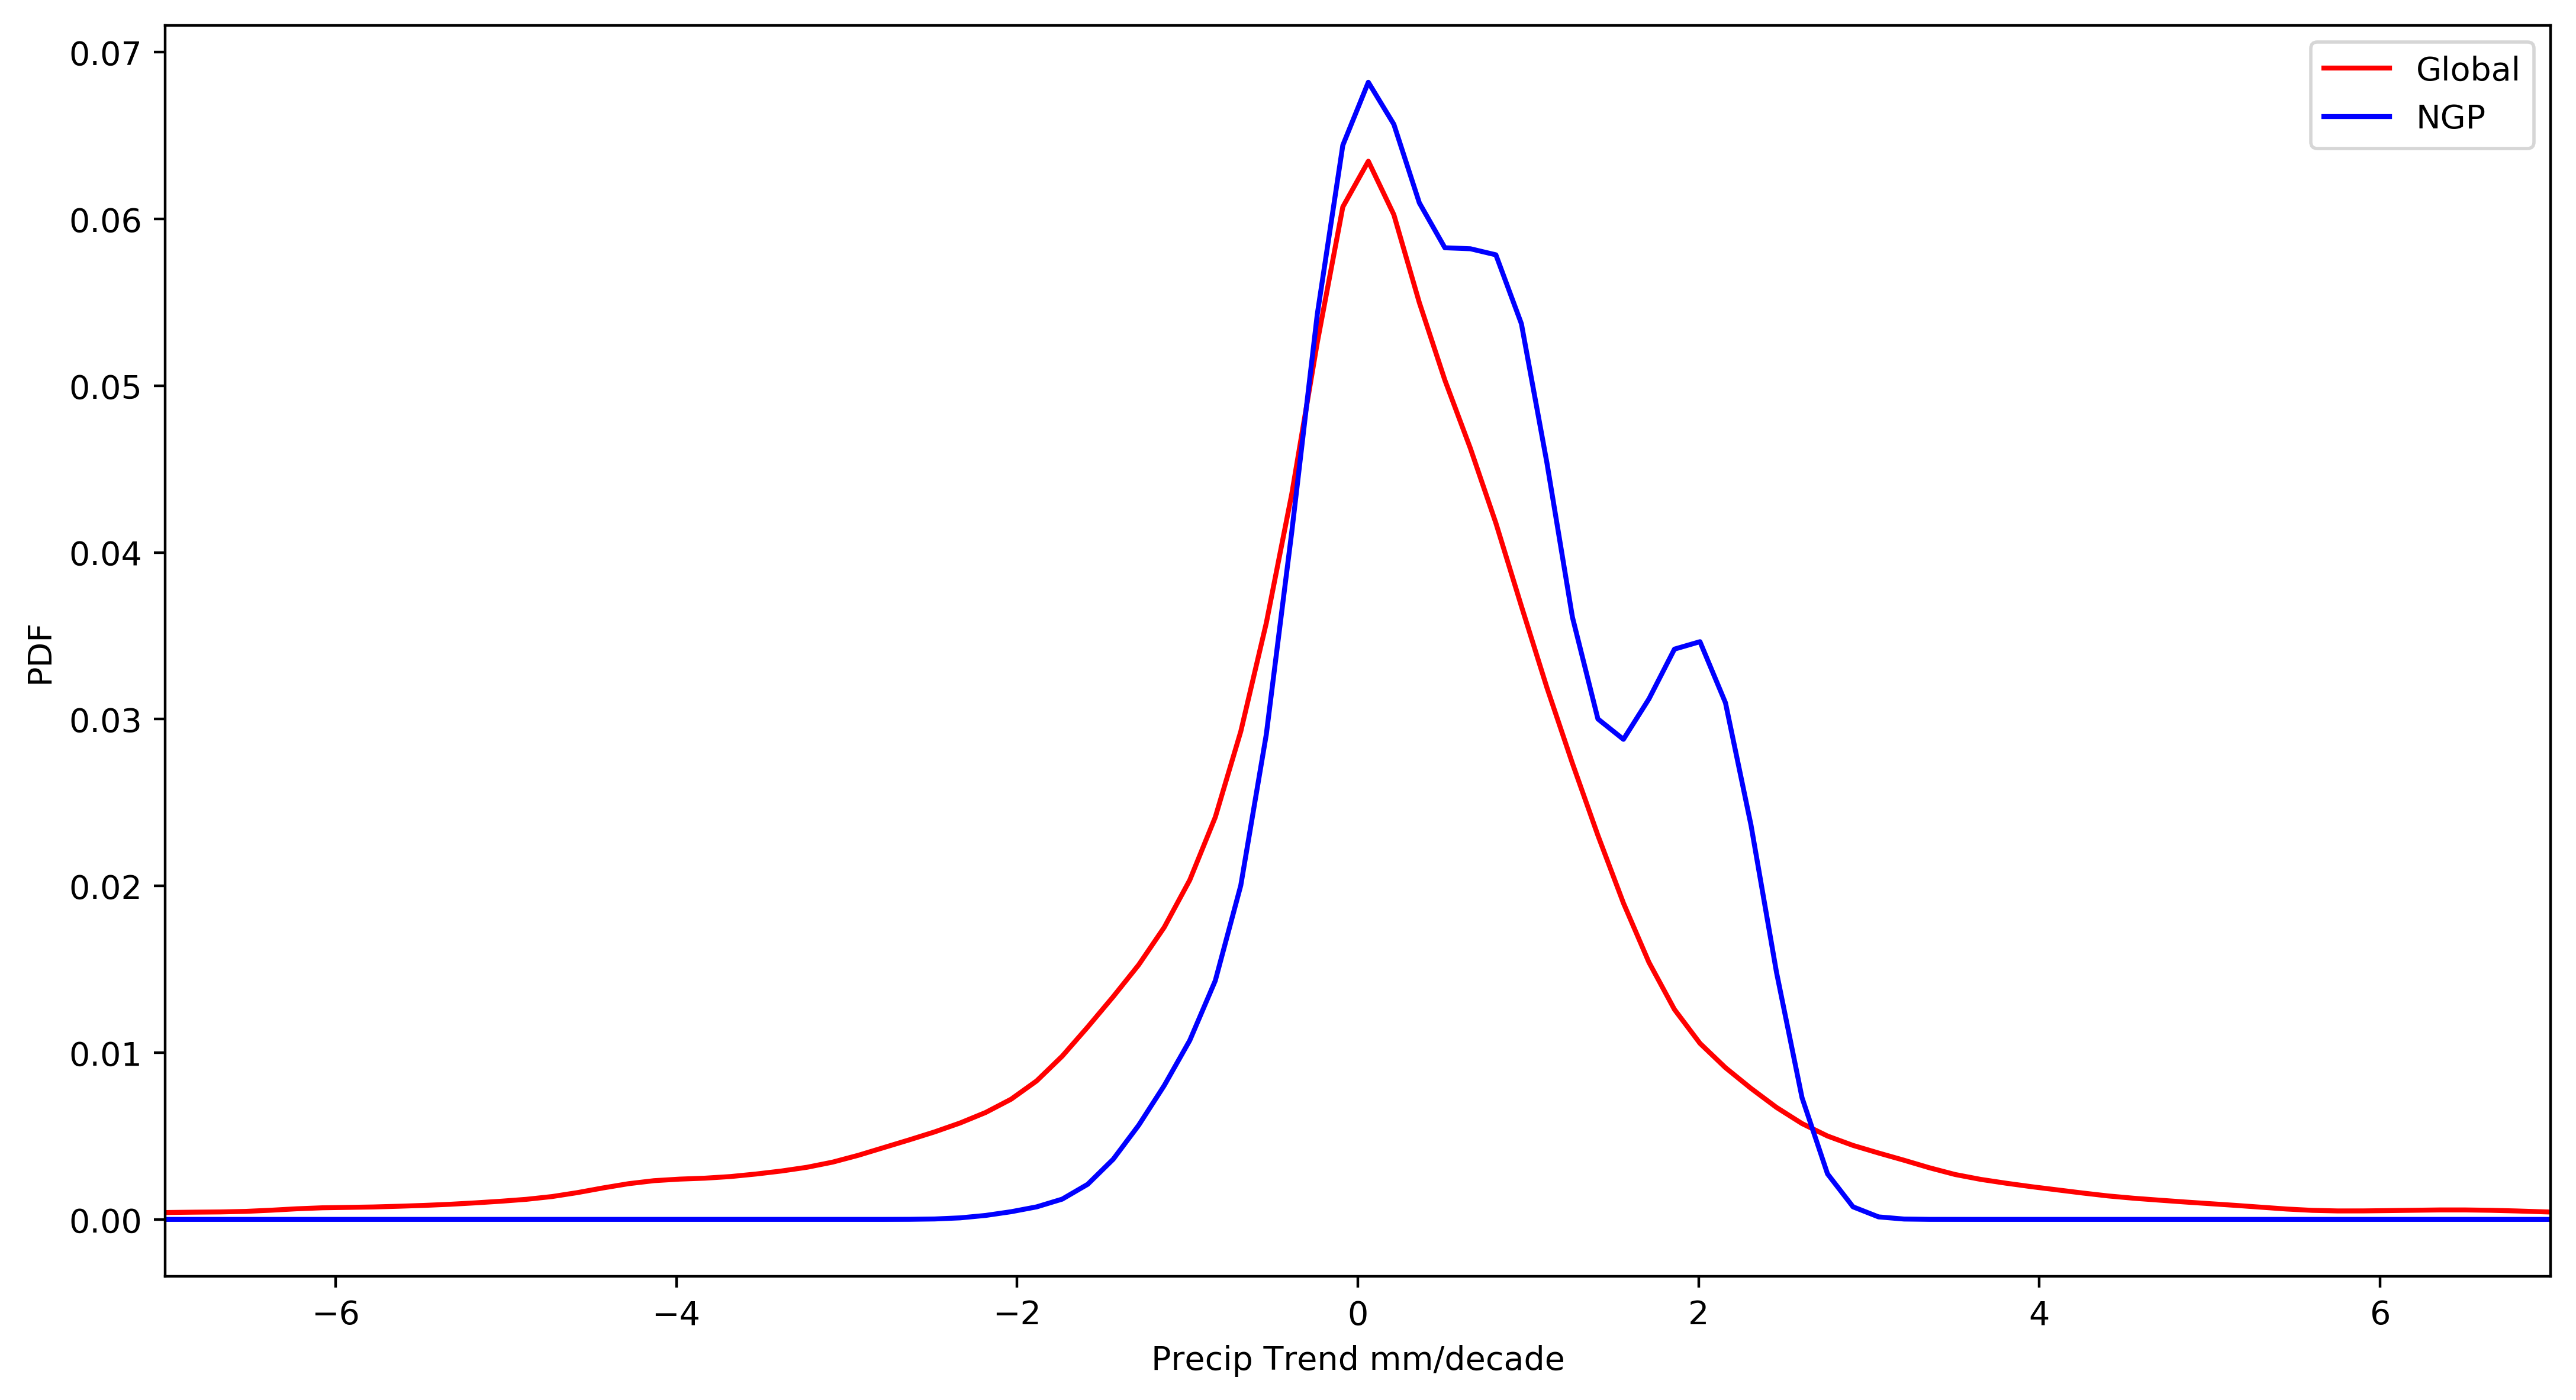

In [20]:
#glob_hist = his

density_globe = sp.stats.gaussian_kde(globe_trend)
density_ngp = sp.stats.gaussian_kde(ngp_trend)
trend_vals = np.linspace(globe_trend.min(),globe_trend.max(),300)

pdf_globe = density_globe(trend_vals)/sum(density_globe(trend_vals))
pdf_ngp = density_ngp(trend_vals)/sum(density_ngp(trend_vals))
#print(gtrend_array_2)
#print(ngp_trend_array_2)
fig, ax = plt.subplots()
ax.plot(trend_vals,pdf_globe,label='Global',color='red')
ax.plot(trend_vals,pdf_ngp,label='NGP',color='blue')

ax.set_xlim([-7,7])
ax.legend()
ax.set_xlabel('Precip Trend mm/decade')
#ax.set_xlabel('Temperature Trend $^\circ$C / Decade')
ax.set_ylabel('PDF')
#plt.xticks(bins_2)
#ax.set_xticks(np.arange(-1,-3),len(gtrend_array_2))
fig.set_size_inches(13,7)
fig.set_dpi(400)
#plt.savefig('/Users/gbromley/Dropbox/Montana_Climate_Project/NGP_Climatology_Paper/Figures/pdf_ngp_global.png')
plt.show()

In [ ]:
kde1 = sp.stats.gaussian_kde(gtrend_array_2)

In [ ]:
gtrend_array_2

In [ ]:
bins_2


In [ ]:
plt.plot(test)

In [ ]:
plt.hist([globe_trend,ngp_trend], bins=100,density=True,alpha=0.5,histtype='step')

In [ ]:
len(ngp_trend)

In [ ]:
len(globe_trend)